In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, sosfilt, sosfreqz, bilinear

$$
\alpha(\theta) = (1 + \frac{\alpha_{\text{min}}}{2}) + (1 - \frac{\alpha_{\text{min}}}{2}) \cos(\frac{\theta}{\theta_{\text{min}}}\pi)
$$

$$
\Delta T(\theta) = 
\begin{cases}
    -\frac{a}{c}\cos(\theta), & \text{if } 0 \le |\theta| < \frac{\pi}{2}\\
    \frac{a}{c}(|\theta|-\frac{\pi}{2}), & \text{if } \frac{\pi}{2} \le |\theta| < \pi \\
\end{cases}
$$

$$
\begin{align}
H_{HS}(\omega, \theta) 
&= \frac{1+j\frac{\alpha \omega}{2 \omega_0}}{1+j\frac{\omega}{2 \omega_0}} \\
&= \frac{1+\frac{j \alpha a 2 \pi f}{c}}{1+\frac{j a 2 \pi f}{c}} \\
\end{align}
$$

$$
H_H(\omega, \theta) = \frac{1+j\frac{\alpha(\theta - \theta_{\text{ear}}) \omega}{2 \omega_0}}{1+j\frac{\omega}{2 \omega_0}} e^{-j \omega T_d(\theta - \theta_{\text{ear}})}\\
$$

In [2]:
def compute_t(theta, a = 0.0875, c = 343):
    if 0 <= np.abs(theta) < np.pi / 2:
        return -a / c * np.cos(theta)
    elif np.pi / 2 <= np.abs(theta) < np.pi / 2:
        return a / c * (np.abs(theta) - np.pi / 2)
    else:
        return NotImplementedError

def compute_alpha(theta, alpha_min = 0.1, theta_min = 150):
    alpha = (1 + alpha_min * 0.5) + (1 - alpha_min * 0.5) * np.cos(theta * np.pi / theta_min)
    return alpha
    
def compute_transfer_function(theta, alpha_min = 0.1, theta_min = 150, a = 0.0875, c = 343):
    alpha = compute_alpha(theta, alpha_min, theta_min)

    f = np.arange(1, 1001) * c / (2 * np.pi * a)
    f = f / 10 # range from 0.1 to 100
    
    pole = alpha * a * np.pi * f / c
    zero = a * np.pi * f / c

    num = 1 + 1j * pole
    den = 1 + 1j * zero
    
    H = num / den
    
    return H

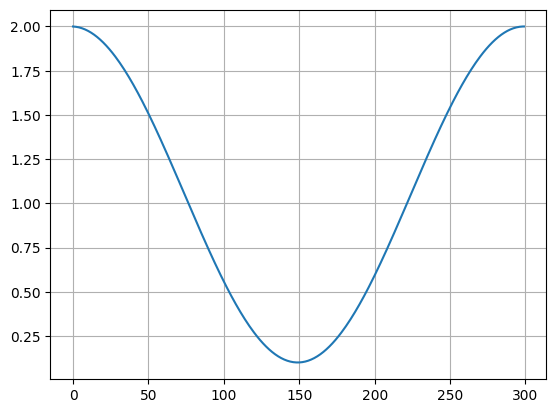

In [3]:
# Given that 150×2=300, we take two times theta_min = 150, resulting in a range from 1 to 300 degrees for theta. 
# We then compute the alpha values over this range using the compute_alpha function and plot the resulting curve.
theta_array = np.linspace(1, 300, 300) 
alpha = compute_alpha(theta_array)

plt.plot(alpha)
plt.grid(True)
plt.show()

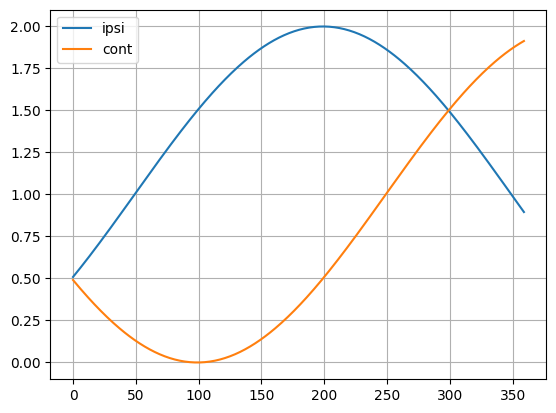

In [4]:
alpha_min = 0.
theta_min = 150
ear_angle_offset = 10

theta_array = np.linspace(1, 360, 360) 

theta_cont = 90 + theta_array / 2 + ear_angle_offset
theta_ipsi = 90 - theta_array / 2 + ear_angle_offset

alpha_ipsi = (1 + alpha_min / 2) + (1 - alpha_min / 2) * np.cos(np.pi * theta_ipsi / theta_min)
alpha_cont = (1 + alpha_min / 2) + (1 - alpha_min / 2) * np.cos(np.pi * theta_cont / theta_min)

plt.plot(alpha_ipsi, label="ipsi")
plt.plot(alpha_cont, label="cont")
plt.grid(True)
plt.legend()
plt.show()

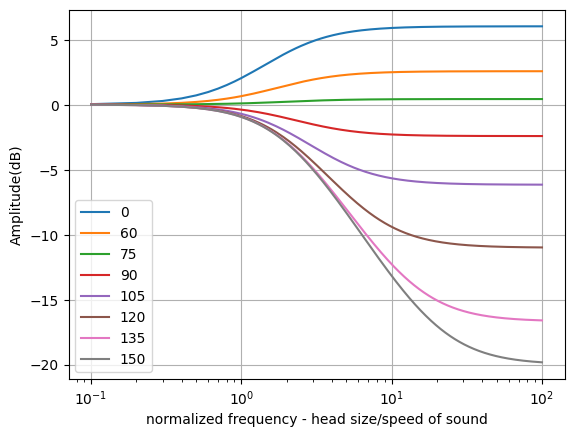

In [5]:
theta_array = np.array([0, 60, 75, 90, 105, 120, 135, 150])
x = np.arange(1, 1001) / 10
for theta in theta_array:
    h = compute_transfer_function(theta)
    a = 20 * np.log10(np.abs(h))
    plt.plot(x, a, label = str(theta))

plt.grid(True)
plt.legend()
plt.xscale('log')
plt.ylabel("Amplitude(dB)")
plt.xlabel("normalized frequency - head size/speed of sound")
plt.show()